# Mental Health in Tech Industry Analysis

# 0. Importing data and libraries

In [579]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [580]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from matplotlib.gridspec import GridSpec


import sqlite3 as sql

sns.set_style("darkgrid")

<IPython.core.display.Javascript object>

# 1. Exploring and pre-processing the dataset

In [581]:
# connect to the database
conn = sql.connect("Data/mental_health.sqlite")

# create a cursor
c = conn.cursor()

<IPython.core.display.Javascript object>

In [582]:
# get tables dataframe
tables = pd.read_sql(
    """
                    SELECT *
                    FROM sqlite_master
                    WHERE type = 'table';
                    """,
    conn,
)
tables

,type,name,tbl_name,rootpage,sql
0,table,Answer,Answer,2,"CREATE TABLE ""Answer"" (\n\t""AnswerText"" VARCHA..."
1,table,Question,Question,1434,"CREATE TABLE ""Question"" (\n\t""questiontext"" VA..."
2,table,Survey,Survey,1438,"CREATE TABLE ""Survey"" (\n\t""SurveyID"" INTEGER ..."


<IPython.core.display.Javascript object>

In [583]:
# getting the column details
pd.read_sql(
    """
            SELECT sql
            FROM sqlite_master
            WHERE type = 'table' AND (name = 'Answer' OR name = 'Question');
            """,
    conn,
).values.tolist()

[['CREATE TABLE "Answer" (\n\t"AnswerText" VARCHAR(10000) NULL,\n\t"SurveyID" INTEGER NULL,\n\t"UserID" INTEGER NULL,\n\t"QuestionID" INTEGER NULL\n)'], ['CREATE TABLE "Question" (\n\t"questiontext" VARCHAR(1000) NULL,\n\t"questionid" INTEGER NULL\n)']]

<IPython.core.display.Javascript object>

We can see that tables Question and Answer permit NULL values for all columns.

Let's take a look into tables that we have:

In [584]:
pd.read_sql(
    """
            SELECT *
            FROM Survey;
            """,
    conn,
)

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


<IPython.core.display.Javascript object>

In [585]:
pd.read_sql(
    """
            SELECT *
            FROM Answer;
            """,
    conn,
)

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


<IPython.core.display.Javascript object>

In [586]:
# how many unique questions were answered by year?
pd.read_sql(
    """
            SELECT SurveyID, COUNT(DISTINCT(QuestionID)) AS num_unique_questions
            FROM Answer
            GROUP BY SurveyID
            ORDER BY SurveyID;
            """,
    conn,
)

,SurveyID,num_unique_questions
0,2014,26
1,2016,60
2,2017,76
3,2018,76
4,2019,76


<IPython.core.display.Javascript object>

We can observe that there are fewer unique questions asked in the 2014-year survey. Thus, let's focus on years from 2016 through 2019.

In [587]:
pd.read_sql(
    """
            SELECT *
            FROM Question;
            """,
    conn,
)

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


<IPython.core.display.Javascript object>

There are a lot of different questions. Let's create a list and get a closer look to define questions for further analysis:

In [588]:
questions_df = pd.read_sql(
    """
                        SELECT DISTINCT questiontext, questionid
                        FROM Question;
                        """,
    conn,
)

questions = dict(zip(questions_df.questionid, questions_df.questiontext))

<IPython.core.display.Javascript object>

In [589]:
for key, val in questions.items():
    print(f"{key}: {val}")

1: What is your age?
2: What is your gender?
3: What country do you live in?
4: If you live in the United States, which state or territory do you live in?
5: Are you self-employed?
6: Do you have a family history of mental illness?
7: Have you ever sought treatment for a mental health disorder from a mental health professional?
8: How many employees does your company or organization have?
9: Is your employer primarily a tech company/organization?
10: Does your employer provide mental health benefits as part of healthcare coverage?
11: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12: Would you bring up a mental health issue with a potential employer in an interview?
13: Is your primary role within your company related to tech/IT?
14: Do you know the options for mental health care available under your employer-provided health coverage?
15: Has your employer ever formally discussed mental hea

<IPython.core.display.Javascript object>

Now, we can define research questions that we would like to explore in this analysis.

## Research Questions:
- What is the distributions of Age, Gender, and Country among responders by year?
- What share of responders have ever sought treatment for a mental health disorder from a mental health professional? Does it correlate with age, gender?
- What share of responders have ever been diagnosed with a mental health disorder? How does it correlate with age, gender?


After we have defined the questions, let's check for unique values for relevant answers:

In [590]:
# get unique answers for age
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS age
            FROM Answer
            WHERE QuestionID = 1;
            """,
    conn,
).values.tolist()

[['37'], ['44'], ['32'], ['31'], ['33'], ['35'], ['39'], ['42'], ['23'], ['29'], ['36'], ['27'], ['46'], ['41'], ['34'], ['30'], ['40'], ['38'], ['50'], ['24'], ['18'], ['28'], ['26'], ['22'], ['19'], ['25'], ['45'], ['21'], ['-29'], ['43'], ['56'], ['60'], ['54'], ['329'], ['55'], ['-1'], ['48'], ['20'], ['57'], ['58'], ['47'], ['62'], ['51'], ['65'], ['49'], ['5'], ['53'], ['61'], ['8'], ['11'], ['72'], ['52'], ['17'], ['63'], ['99'], ['323'], ['3'], ['66'], ['59'], ['15'], ['74'], ['70'], ['64'], ['67'], ['0']]

<IPython.core.display.Javascript object>

In [591]:
# get unique answers for gender
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS gender
            FROM Answer
            WHERE QuestionID = 2;
            """,
    conn,
).values.tolist()

[['Female'], ['Male'], ['Male-ish'], ['Trans-female'], ['something kinda male?'], ['queer/she/they'], ['non-binary'], ['Nah'], ['All'], ['Enby'], ['fluid'], ['Genderqueer'], ['Androgyne'], ['Agender'], ['Guy (-ish) ^_^'], ['male leaning androgynous'], ['Trans woman'], ['Neuter'], ['Female (trans)'], ['queer'], ['A little about you'], ['p'], ['ostensibly male, unsure what that really means'], ['Bigender'], ['Female assigned at birth'], ['fm'], ['Transitioned, M2F'], ['Genderfluid (born female)'], ['Other/Transfeminine'], ['Female or Multi-Gender Femme'], ['Androgynous'], ['male 9:1 female, roughly'], ['-1'], ['Other'], ['nb masculine'], ['none of your business'], ['genderqueer'], ['Human'], ['Genderfluid'], ['genderqueer woman'], ['mtf'], ['Queer'], ['Fluid'], ['Male/genderqueer'], ['Nonbinary'], ['human'], ['Unicorn'], ['Male (trans, FtM)'], ['Genderflux demi-girl'], ['female-bodied; no feelings about gender'], ['AFAB'], ['Transgender woman'], ['male'], ['female'], ['male/androgynous']

<IPython.core.display.Javascript object>

In [592]:
# get unique answers for countries
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS country
            FROM Answer
            WHERE QuestionID = 3;
            """,
    conn,
).values.tolist()

[['United States'], ['Canada'], ['United Kingdom'], ['Bulgaria'], ['France'], ['Portugal'], ['Netherlands'], ['Switzerland'], ['Poland'], ['Australia'], ['Germany'], ['Russia'], ['Mexico'], ['Brazil'], ['Slovenia'], ['Costa Rica'], ['Austria'], ['Ireland'], ['India'], ['South Africa'], ['Italy'], ['Sweden'], ['Colombia'], ['Latvia'], ['Romania'], ['Belgium'], ['New Zealand'], ['Zimbabwe'], ['Spain'], ['Finland'], ['Uruguay'], ['Israel'], ['Bosnia and Herzegovina'], ['Hungary'], ['Singapore'], ['Japan'], ['Nigeria'], ['Croatia'], ['Norway'], ['Thailand'], ['Denmark'], ['Bahamas, The'], ['Greece'], ['Moldova'], ['Georgia'], ['China'], ['Czech Republic'], ['Philippines'], ['United States of America'], ['Lithuania'], ['Venezuela'], ['Argentina'], ['Vietnam'], ['Slovakia'], ['Bangladesh'], ['Algeria'], ['Pakistan'], ['Afghanistan'], ['Other'], ['Brunei'], ['Iran'], ['Ecuador'], ['Chile'], ['Guatemala'], ['Taiwan'], ['Serbia'], ['Estonia'], ['Iceland'], ['Indonesia'], ['Jordan'], ['Ukraine']

<IPython.core.display.Javascript object>

In [593]:
# get unique answers for race
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS race
            FROM Answer
            WHERE QuestionID = 89;
            """,
    conn,
).values.tolist()

[['-1'], ['White'], ['More than one of the above'], ['Asian'], ['Black or African American'], ['I prefer not to answer'], ['American Indian or Alaska Native'], ['Hispanic'], ['White Hispanic'], ['European American'], ['Caucasian']]

<IPython.core.display.Javascript object>

By observing the unique answers for questions about age, gender,country and race, we can see that there are '-1' values which signify missing values. Also, answers about gender contain a lot of uniquely created variants. And there are some extreme values that don't seem plausible in answers about age.

In [594]:
# get unique answers for self_employed question
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS self_employed
            FROM Answer
            WHERE QuestionID = 5;
            """,
    conn,
).values.tolist()

[['-1'], ['1'], ['0']]

<IPython.core.display.Javascript object>

In [595]:
# get unique answers for the question "Have you ever sought treatment for mental health issues?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS sought_treatment
            FROM Answer
            WHERE QuestionID = 7;
            """,
    conn,
).values.tolist()

[['1'], ['0']]

<IPython.core.display.Javascript object>

In [596]:
# get unique answers for question "Does the employer provide mental health benefits?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS mental_health_benefits
            FROM Answer
            WHERE QuestionID = 10;
            """,
    conn,
).values.tolist()

[['Yes'], ["Don't know"], ['No'], ['Not eligible for coverage / NA'], ['-1'], ["I don't know"]]

<IPython.core.display.Javascript object>

In [597]:
# get unique answers for question "Ever had a mental health disorder?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS mental_health_disorder
            FROM Answer
            WHERE QuestionID = 32;
            """,
    conn,
).values.tolist()

[['Yes'], ['Maybe'], ['No'], ['Possibly'], ['-1'], ["Don't Know"]]

<IPython.core.display.Javascript object>

In [598]:
# get unique answers for question "Ever have been diagnosed with a mental health disorder?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS diagnosed
            FROM Answer
            WHERE QuestionID = 34;
            """,
    conn,
).values.tolist()

[['Yes'], ['No'], ['-1']]

<IPython.core.display.Javascript object>

In [599]:
# get unique answers for question "Ever had a mental health disorder?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS mental_health_disorder
            FROM Answer
            WHERE QuestionID = 32;
            """,
    conn,
).values.tolist()

[['Yes'], ['Maybe'], ['No'], ['Possibly'], ['-1'], ["Don't Know"]]

<IPython.core.display.Javascript object>

In [600]:
# get unique answers for question "Do you reveal your mental health disorder to your coworkers or employers?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS work_reveal
            FROM Answer
            WHERE QuestionID = 53;
            """,
    conn,
).values.tolist()

[['-1'], ['Sometimes, if it comes up'], ['No, because it would impact me negatively'], ['Not applicable to me'], ['Yes, always'], ["No, because it doesn't matter"]]

<IPython.core.display.Javascript object>

In [601]:
# get unique answers for question "Are you openly identified at work as a person with a mental health disorder?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS openly_identified
            FROM Answer
            WHERE QuestionID = 78;
            """,
    conn,
).values.tolist()

[['0'], ['1'], ['-1']]

<IPython.core.display.Javascript object>

In [602]:
# get unique answers for question "How being openly identified at work has influenced your career?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS identified_affect
            FROM Answer
            WHERE QuestionID = 80;
            """,
    conn,
).values.tolist()

[['-1'], ['3'], ['2'], ['6'], ['0'], ['4'], ['10'], ['7'], ['5'], ['1'], ['8']]

<IPython.core.display.Javascript object>

In [603]:
# get unique answers for question "Do you work remotely?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS remote
            FROM Answer
            WHERE QuestionID = 93;
            """,
    conn,
).values.tolist()

[['No'], ['Yes']]

<IPython.core.display.Javascript object>

In [604]:
# get unique answers for question "Do you work remotely?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS remote_work
            FROM Answer
            WHERE QuestionID = 118;
            """,
    conn,
).values.tolist()

[['Sometimes'], ['Never'], ['Always']]

<IPython.core.display.Javascript object>

In [605]:
# get unique answers for question "Do you think discussing a mental health issue would have a negative effect?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS discussion_effect
            FROM Answer
            WHERE QuestionID = 104;
            """,
    conn,
).values.tolist()

[['No'], ['Maybe'], ['-1'], ['Yes']]

<IPython.core.display.Javascript object>

In [606]:
# get unique answers for question "Is your primary role related to tech/IT?"
pd.read_sql(
    """
            SELECT DISTINCT AnswerText AS tech
            FROM Answer
            WHERE QuestionID = 13;
            """,
    conn,
).values.tolist()

[['-1'], ['1'], ['0']]

<IPython.core.display.Javascript object>

## 1.1. Pre-processing the dataset

Let's join the tables that we will need for further analysis. Since we are interested only in answered questions, we will perform an inner join.

In [607]:
joined_df = pd.read_sql(
    """
            SELECT a.UserID AS user_id,
                   a.SurveyID AS survey_id,
                   a.QuestionID AS question_id,
                   q.questiontext AS question,
                   a.AnswerText AS answer
            FROM Question q
            INNER JOIN Answer a
            ON a.questionID = q.questionid
            WHERE a.SurveyID != 2014
            ORDER BY survey_id, user_id, question_id;
            """,
    conn,
)

<IPython.core.display.Javascript object>

In [608]:
joined_df

,user_id,survey_id,question_id,question,answer
0,1261,2016,1,What is your age?,39
1,1261,2016,2,What is your gender?,Male
2,1261,2016,3,What country do you live in?,United Kingdom
3,1261,2016,4,"If you live in the United States, which state ...",-1
4,1261,2016,5,Are you self-employed?,0
...,...,...,...,...,...
204133,4218,2019,85,"Overall, how well do you think the tech indust...",3
204134,4218,2019,86,Briefly describe what you think the industry a...,reduce stigma. offer options for part time wor...
204135,4218,2019,87,If there is anything else you would like to te...,I've had to drive all of the progress in menta...
204136,4218,2019,88,Would you be willing to talk to one of us more...,1


<IPython.core.display.Javascript object>

Since all the columns permit NULL values, let's check whether we have those.

Note: there are value -1 in answers which signifies Null values, so we will replace it to np.nan.

In [609]:
joined_df = joined_df.replace({"-1": np.nan})
joined_df.isna().sum() / joined_df.count()

user_id        0.000000
survey_id      0.000000
question_id    0.000000
question       0.000000
answer         0.366038
dtype: float64

<IPython.core.display.Javascript object>

We can observe that answer column has around a third part of values missing.

Let's also check for duplicated values (though there should be no duplicate values after the INNER JOIN)

In [610]:
len(joined_df) - len(joined_df.drop_duplicates())

0

<IPython.core.display.Javascript object>

 # 2. Exploratory Data Analysis and Answering Research Questions

#### Define necessary functions:

In [611]:
xticklabels_d = {
    "horizontalalignment": "right",
    "fontweight": "light",
    "fontsize": "x-large",
}

<IPython.core.display.Javascript object>

In [612]:
def plot_sns_barplot(
    data,
    x: str,
    y: str,
    x_label: str,
    y_label: str,
    title: str,
    hue=None,
    xtick_rot: int = 65,
    max_len_xtick_labels: int = 25,
    xticklabels: dict = xticklabels_d,
    my_figsize: (int, int) = (10, 7),
):
    """
    Function to automate seaborn
    barplot plotting.
    """
    # Figure Size
    fig = plt.figure(figsize=my_figsize)

    # Bar Plot
    ax = sns.barplot(x=data[x], y=data[y], hue=hue)
    f = lambda x: textwrap.fill(x.get_text(), max_len_xtick_labels)
    ax.set_xticklabels(map(f, ax.get_xticklabels()), rotation=xtick_rot, **xticklabels)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    ax.plot()

<IPython.core.display.Javascript object>

In [613]:
def plot_sns_countplot(
    data,
    x: str,
    plot_order,
    x_label: str,
    y_label: str,
    title: str,
    hue=None,
    xtick_rot: int = 65,
    max_len_xtick_labels: int = 25,
    xticklabels: dict = xticklabels_d,
    my_figsize: (int, int) = (10, 7),
):
    """
    Function to automate seaborn
    countplot plotting.
    """
    plt.figure(figsize=my_figsize)
    ax = sns.countplot(data=data, x=x, order=plot_order, hue=hue)
    f = lambda x: textwrap.fill(x.get_text(), max_len_xtick_labels)
    ax.set_xticklabels(map(f, ax.get_xticklabels()), rotation=xtick_rot, **xticklabels)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    ax.plot()

<IPython.core.display.Javascript object>

In [614]:
def visualize_violinplot(df, x: str, y: str, hue: str = None):
    """
    Function to plot a violin plot with seaborn.
    """
    # Create the violin plot
    sns.violinplot(x=x, y=y, data=df, hue=hue)

    # Set the plot title and axes labels
    plt.title(f"{y.capitalize()} distribution by {x.capitalize()}")
    plt.xlabel(x.capitalize())
    plt.ylabel(y.capitalize())

    if hue is not None:
        plt.legend(title=hue, loc="upper right", bbox_to_anchor=(1.2, 1))
        plt.title(
            f"{y.capitalize()} distribution by {x.capitalize()} and {hue.capitalize()}"
        )
    # Show the plot
    plt.show()

<IPython.core.display.Javascript object>

In [615]:
def visualize_percentage_lineplot_by_year(my_df, my_col: str, ylim):
    """
    Function to visualize a line plot with the share of responders
    where my_col is True, by year, by gender.
    """
    # calculate the percentage of users by gender and year
    df_percentage = my_df.groupby(["year", "gender"])[my_col].mean().reset_index()

    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df_percentage, x="year", y=my_col, hue="gender")
    plt.ylim(*ylim)
    plt.xticks(df_percentage["year"].unique())

    plt.title(f"Share of responders where {my_col} is True, by gender, by year")
    plt.xlabel("Year")
    plt.ylabel("Share of responders")

    plt.show()

<IPython.core.display.Javascript object>

In [616]:
def plot_count_percent_barplots_by_age_group(my_df, my_col: str, my_order=None):
    """
    Function to visualize two plots side by side.
    The first plot shows the total count for each age band.
    The second plot shows percentage of responders where my_col is 1.
    """

    fig = plt.figure(figsize=(12, 6))
    grid = GridSpec(1, 2)

    ax1 = fig.add_subplot(grid[0, 0])

    sns.countplot(
        data=my_df.dropna(subset=[my_col]),
        x="age_group",
        hue=my_col,
        order=my_order,
        ax=ax1,
    )
    ax1.set(xlabel="Age groups", ylabel="Count")

    ax2 = fig.add_subplot(grid[0, 1])

    sns.barplot(
        data=my_df.dropna(subset=[my_col]),
        x="age_group",
        y=my_col,
        order=my_order,
        estimator=lambda x: sum(x) / len(x),
        errorbar=None,
        ax=ax2,
    )
    ax2.set(xlabel="Age groups", ylabel=f"Share of respondents where {my_col} is true")
    ax2.set_ylim(0, 1)

    fig.suptitle(f"{my_col} values for each age band")

    plt.subplots_adjust(wspace=0.3)

    plt.show()

<IPython.core.display.Javascript object>

## 2.1. What is the distributions of Age, Gender, and Country among responders by year?

In [617]:
query_2_1 = """
            SELECT SurveyID AS year,
                   UserID AS user,
                   MAX(CASE WHEN QuestionID = 1 AND AnswerText != '-1' THEN CAST(AnswerText AS INTEGER) END) AS age,
                   MAX(CASE WHEN QuestionID = 3 AND AnswerText != '-1' THEN AnswerText END) AS country,
                   MAX(CASE
                        WHEN AnswerText BETWEEN 18 AND 24 THEN '18-24'
                        WHEN AnswerText BETWEEN 25 AND 34 THEN '25-34'
                        WHEN AnswerText BETWEEN 35 AND 44 THEN '35-44'
                        WHEN AnswerText BETWEEN 45 AND 54 THEN '45-54'
                        WHEN AnswerText BETWEEN 55 AND 64 THEN '55-64'
                        WHEN AnswerText BETWEEN 65 AND 100 THEN '65+'
                   END) AS age_group,
                   MAX(CASE
                        WHEN (QuestionID = 2 AND UPPER(AnswerText) IN ('MALE', 'MASCULINO')) THEN 'male'
                        WHEN (QuestionID = 2 AND UPPER(AnswerText) IN ('FEMALE', 'FEMMINA')) THEN 'female'
                        WHEN (QuestionID = 2 AND UPPER(AnswerText) NOT IN ('FEMALE', 'FEMMINA', 'MALE', 'MASCULINO')) THEN 'other'
                    END) AS gender
            FROM Answer
            WHERE QuestionID IN (1, 2, 3)
                  AND year != 2014
                  AND AnswerText != '-1'
            GROUP BY year, user
            ORDER BY year, user;
            """

df_age_gender_country = pd.read_sql(query_2_1, conn)

<IPython.core.display.Javascript object>

In [618]:
df_age_gender_country

,year,user,age,country,age_group,gender
0,2016,1261,39,United Kingdom,35-44,male
1,2016,1262,29,United States of America,25-34,male
2,2016,1263,38,United Kingdom,35-44,male
3,2016,1264,43,United Kingdom,35-44,male
4,2016,1265,43,United States of America,35-44,female
...,...,...,...,...,...,...
2951,2019,4214,27,India,25-34,male
2952,2019,4215,48,United States of America,45-54,male
2953,2019,4216,50,India,45-54,male
2954,2019,4217,30,India,25-34,female


<IPython.core.display.Javascript object>

Let's handle missing values:

In [619]:
df_age_gender_country.isna().sum()

year          0
user          0
age           0
country       0
age_group    12
gender       22
dtype: int64

<IPython.core.display.Javascript object>

There are not so many missing values, so we will drop the rows with NaNs

In [620]:
df_age_gender_country.dropna(inplace=True)

<IPython.core.display.Javascript object>

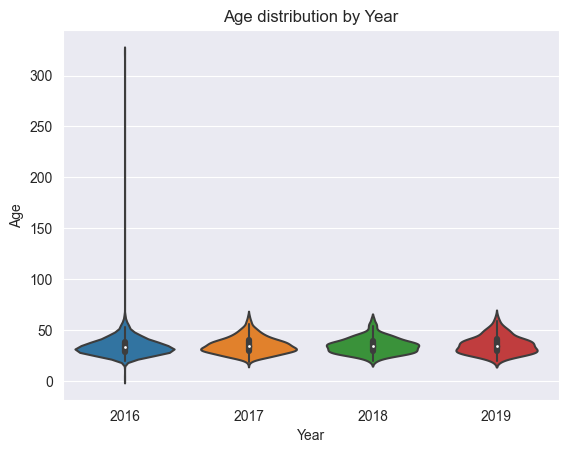

<IPython.core.display.Javascript object>

In [621]:
visualize_violinplot(df_age_gender_country, x="year", y="age")

In [622]:
pd.read_sql(
    """
            SELECT
            AnswerText
            FROM Answer
            WHERE QuestionID=1 AND SurveyID != 2014 AND CAST(AnswerText AS INTEGER) > 100;
            """,
    conn,
)

,AnswerText
0,323


<IPython.core.display.Javascript object>

In [623]:
pd.read_sql(
    """
            SELECT DISTINCT
            AnswerText
            FROM Answer
            WHERE QuestionID=1 AND SurveyID != 2014 AND CAST(AnswerText AS INTEGER) < 15;
            """,
    conn,
)

,AnswerText
0,3
1,-1
2,0


<IPython.core.display.Javascript object>

There seems to be an extreme upper outlier and a couple of unlikely lower outliers in the age column. So, let's get rid of them:

In [624]:
temp_conditions = (df_age_gender_country["age"] == 323) | (
    df_age_gender_country["age"] < 15
)
df_age_gender_country = df_age_gender_country[~temp_conditions]

<IPython.core.display.Javascript object>

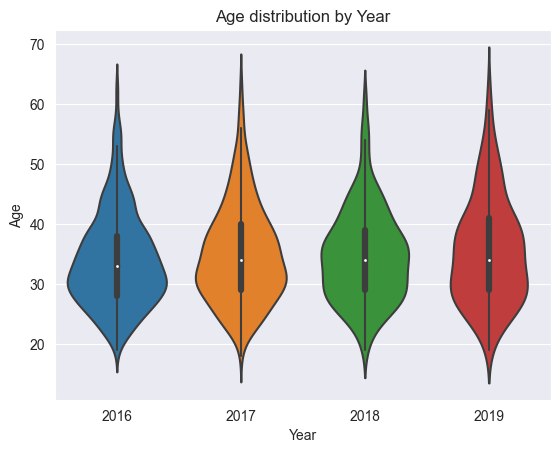

<IPython.core.display.Javascript object>

In [625]:
visualize_violinplot(df_age_gender_country, x="year", y="age")

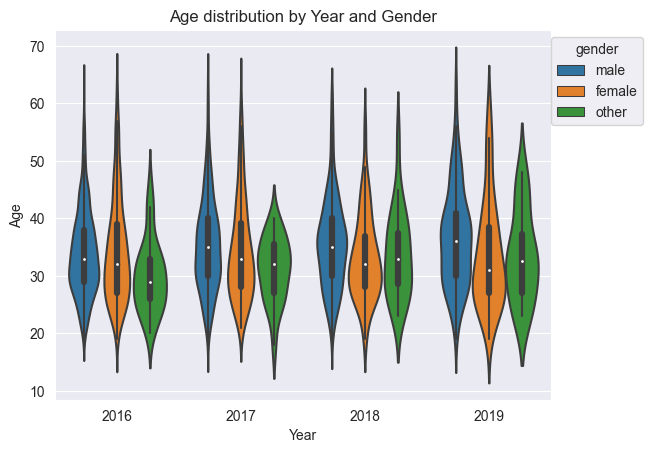

<IPython.core.display.Javascript object>

In [626]:
visualize_violinplot(df_age_gender_country, x="year", y="age", hue="gender")

It seems like male responders tend to be older than other ones. And in 2016-2017 years, people who identified as of 'other' gender were younger than the female group, but in the last two years older responders in 'other' gender group joined the survey. The age of most responders seems to be between 25 and 45.

Now, let's explore the most active participant countries by each year:

In [627]:
query_2_1_2 = """
            SELECT t2.year, t2.country, t2.responders_count
            FROM (
              SELECT t1.year, t1.country, t1.responders_count,
                     ROW_NUMBER() OVER (PARTITION BY year ORDER BY responders_count DESC) AS row_num
              FROM (
                SELECT SurveyID AS year,
                       CASE WHEN QuestionID = 3 AND AnswerText != '-1' THEN AnswerText END AS country,
                       COUNT(DISTINCT UserID) AS responders_count
                FROM Answer
                WHERE QuestionID = 3
                      AND year != 2014
                      AND AnswerText != '-1'
                GROUP BY year, country
              ) AS t1
            ) AS t2
            WHERE row_num <= 5
            ORDER BY t2.year, t2.responders_count DESC;

            """

country_responders_count = pd.read_sql(query_2_1_2, conn)

<IPython.core.display.Javascript object>

In [697]:
country_responders_count

,year,country,responders_count
0,2016,United States of America,840
1,2016,United Kingdom,180
2,2016,Canada,78
3,2016,Germany,58
4,2016,Netherlands,48
5,2017,United States of America,497
6,2017,United Kingdom,66
7,2017,Canada,26
8,2017,Germany,22
9,2017,France,17


<IPython.core.display.Javascript object>

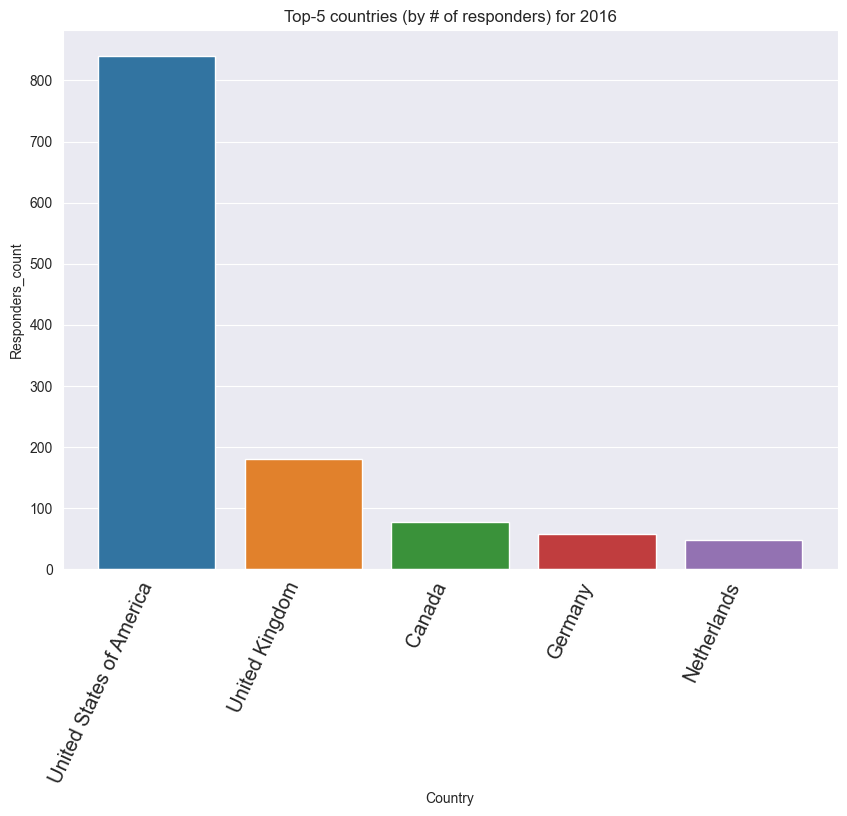

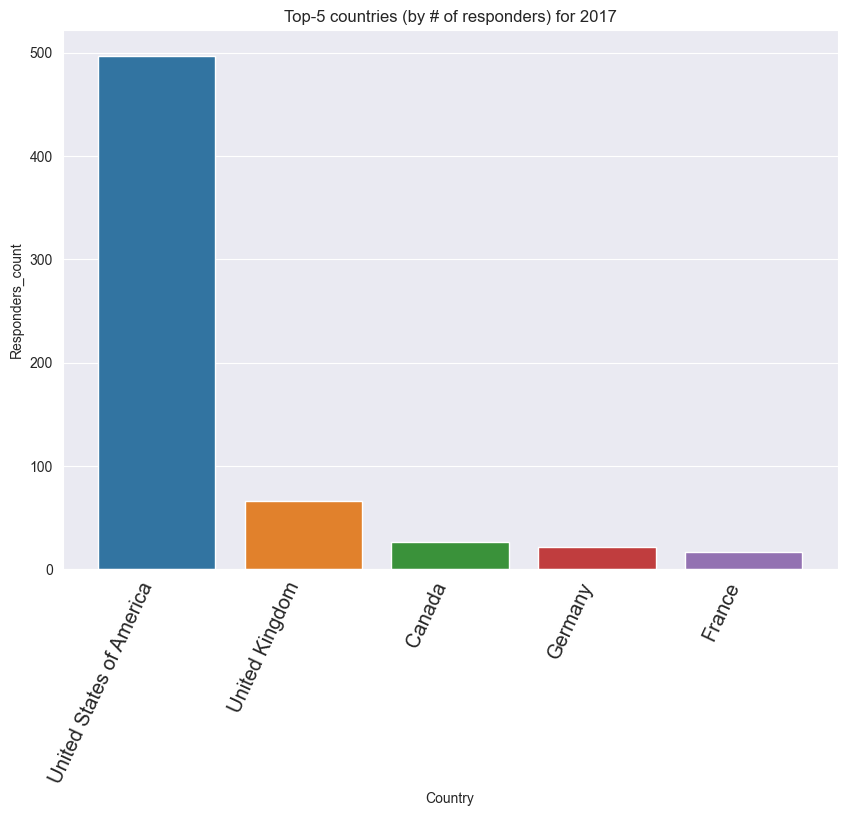

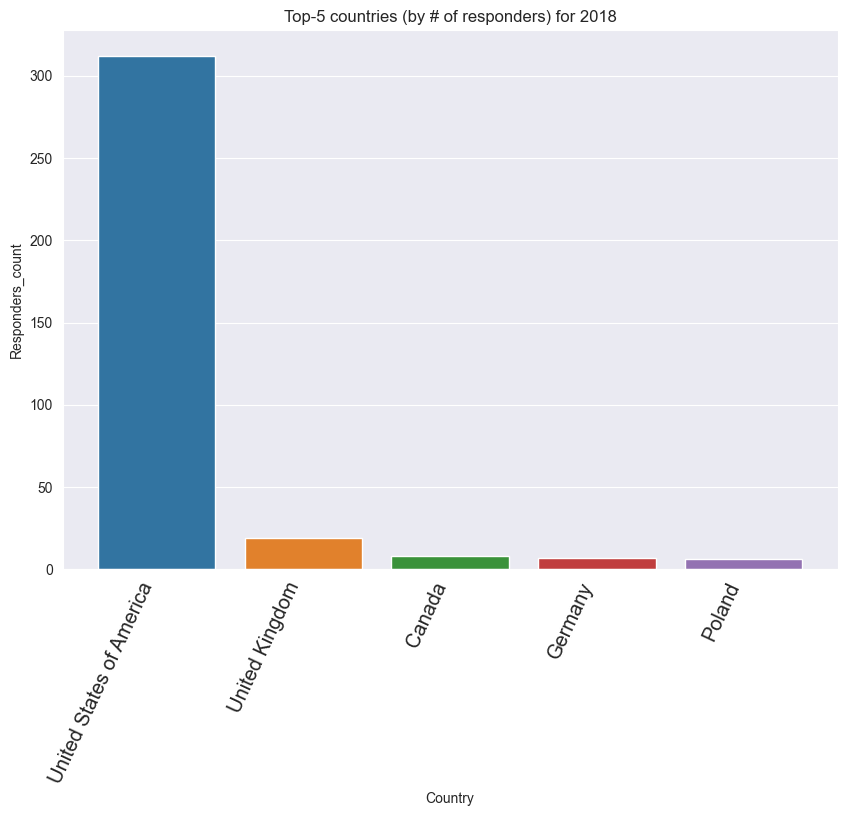

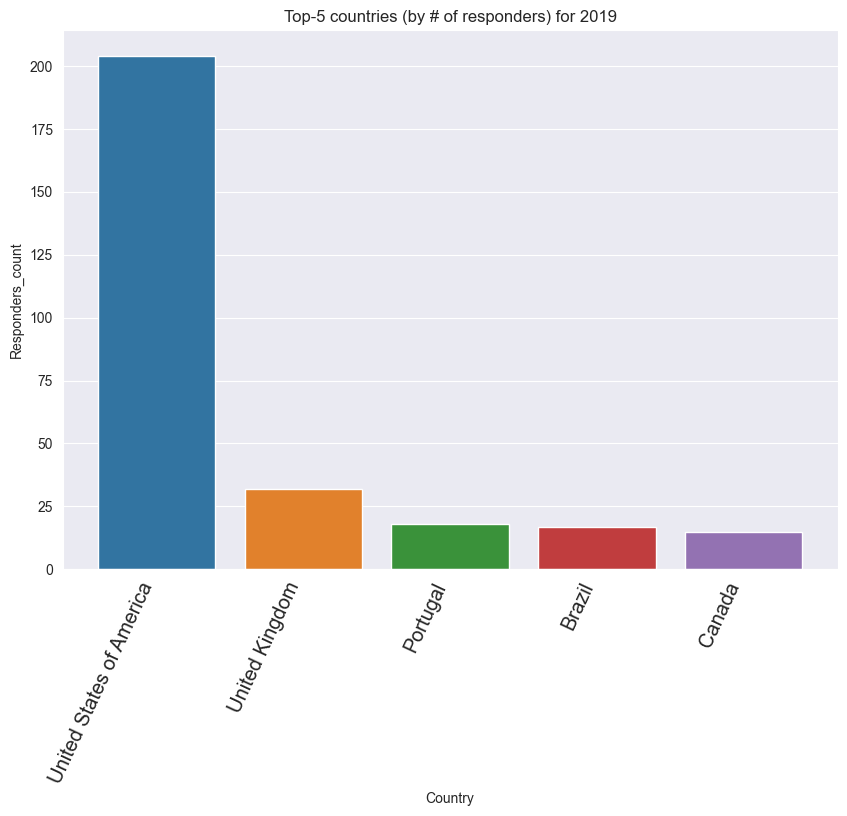

<IPython.core.display.Javascript object>

In [628]:
for survey_year in country_responders_count.year.unique().tolist():
    plot_sns_barplot(
        country_responders_count[country_responders_count.year == survey_year].nlargest(
            5, "responders_count"
        ),
        x="country",
        y="responders_count",
        x_label="Country",
        y_label="Responders_count",
        title=f"Top-5 countries (by # of responders) for {survey_year}",
    )

The number of total survey participants has been decreased throughout the years. The majority of responders come from the United States of America, and a fair share of them - from the United Kingdom and Canada, and in some years - Germany. Other top countries vary from year to year. We can assume that the majority of participants come from countries where mental health is talked about and is considered important. It would be useful to get more people from other countries involved in the future.

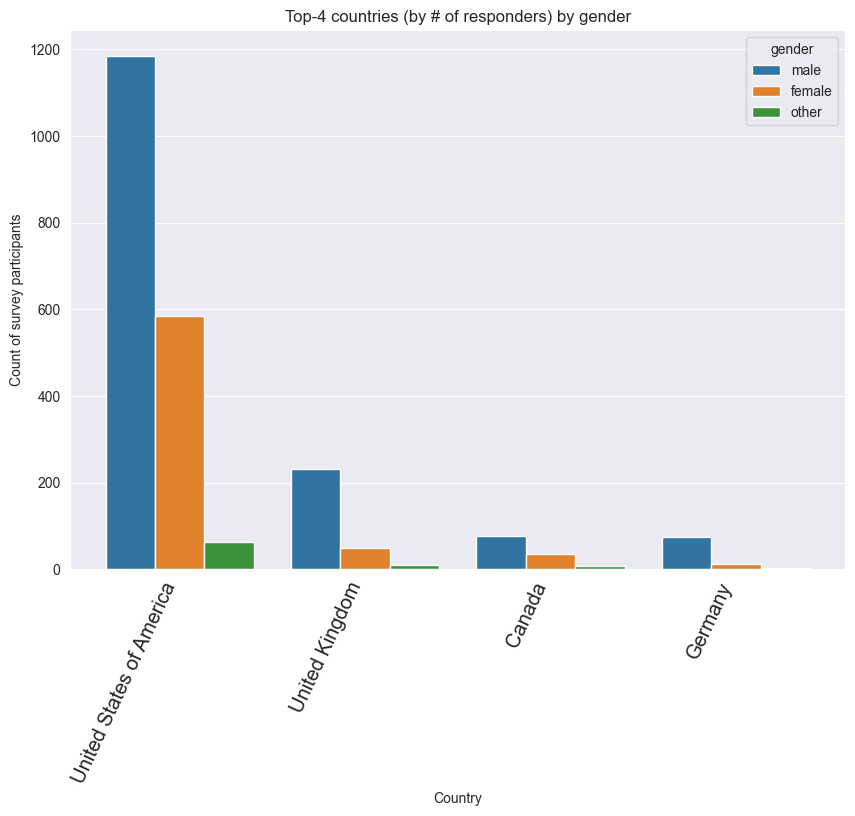

<IPython.core.display.Javascript object>

In [629]:
top_countries = ["United States of America", "United Kingdom", "Canada", "Germany"]

plot_sns_countplot(
    df_age_gender_country[df_age_gender_country["country"].isin(top_countries)],
    x="country",
    x_label="Country",
    y_label="Count of survey participants",
    plot_order=top_countries,
    title=f"Top-4 countries (by # of responders) by gender",
    hue="gender",
)

We can see that in the USA and Canada, there are circa 50% more male responders than female ones. But for the UK and Germany there are considerably smaller share of female responders.

## What share of responders have ever sought treatment for a mental health disorder from a mental health professional? Does it correlate with age and gender?

In [630]:
query_2_2 = """
            SELECT UserID AS user,
                   CAST(AnswerText AS INTEGER) AS sought_treatment
            FROM Answer
            WHERE QuestionID = 7
                  AND SurveyID != 2014
                  AND AnswerText != '-1'
            GROUP BY user
            ORDER BY user;
            """

sought_treatment = pd.read_sql(query_2_2, conn)

<IPython.core.display.Javascript object>

In [631]:
# join two dataframes to get full data
merged_df_sought_treatment = df_age_gender_country.merge(
    sought_treatment, on="user", how="inner"
)

<IPython.core.display.Javascript object>

Let's see how the percentage of responders who have sought treatment from a mental health professional changed throughout years:

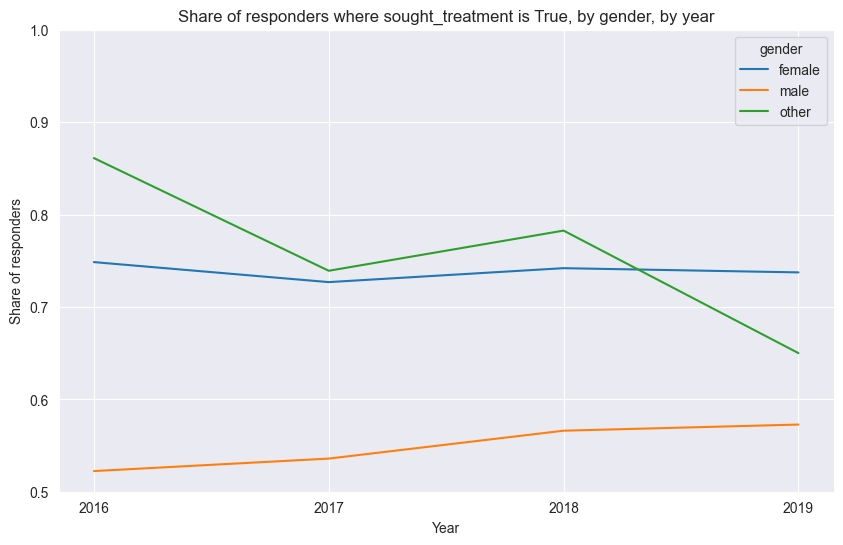

<IPython.core.display.Javascript object>

In [632]:
visualize_percentage_lineplot_by_year(
    merged_df_sought_treatment, "sought_treatment", (0.5, 1)
)

It seems like male participants have the lowest rate in seeking professional help. In the last two years the percentage increases slightly, but it's still significantly lower than for female and other-gender participants. The share of the participants who identify themselves other than male/female decreased in time by around 20%.

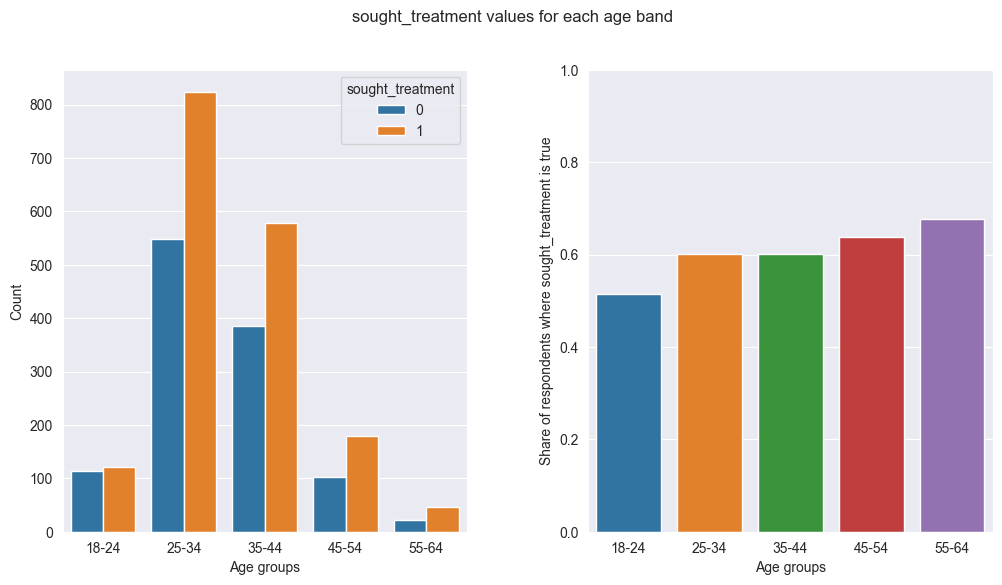

<IPython.core.display.Javascript object>

In [633]:
age_order = ["18-24", "25-34", "35-44", "45-54", "55-64"]
plot_count_percent_barplots_by_age_group(
    merged_df_sought_treatment, "sought_treatment", my_order=age_order
)

In our dataset, the majority of responders have sought treatment at some point in time.  Higher share of older participants answered that they have sought treatment from a mental health professional.

## 2.3. What share of responders have ever been diagnosed with a mental health disorder? How does it correlate with age, gender?

In [634]:
query_2_3 = """
            SELECT UserID AS user,
                   CASE WHEN AnswerText = 'Yes' THEN 1
                        WHEN AnswerText = 'No' THEN 0
                   END AS diagnosed
            FROM Answer
            WHERE QuestionID = 34
                  AND SurveyID != 2014
                  AND AnswerText != '-1'
            GROUP BY user
            ORDER BY user;
            """

diagnosed = pd.read_sql(query_2_3, conn)

<IPython.core.display.Javascript object>

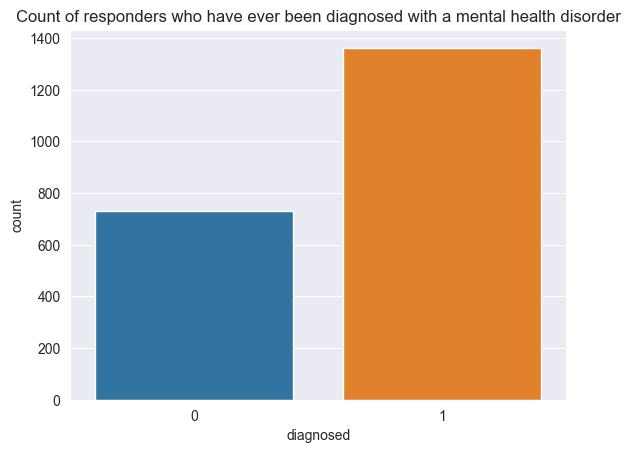

<IPython.core.display.Javascript object>

In [635]:
sns.countplot(x=diagnosed.diagnosed)
plt.title(
    "Count of responders who have ever been diagnosed with a mental health disorder"
)
plt.show()

In [636]:
# join two dataframes to get full data
merged_df_diagnosed = df_age_gender_country.merge(diagnosed, on="user", how="inner")

<IPython.core.display.Javascript object>

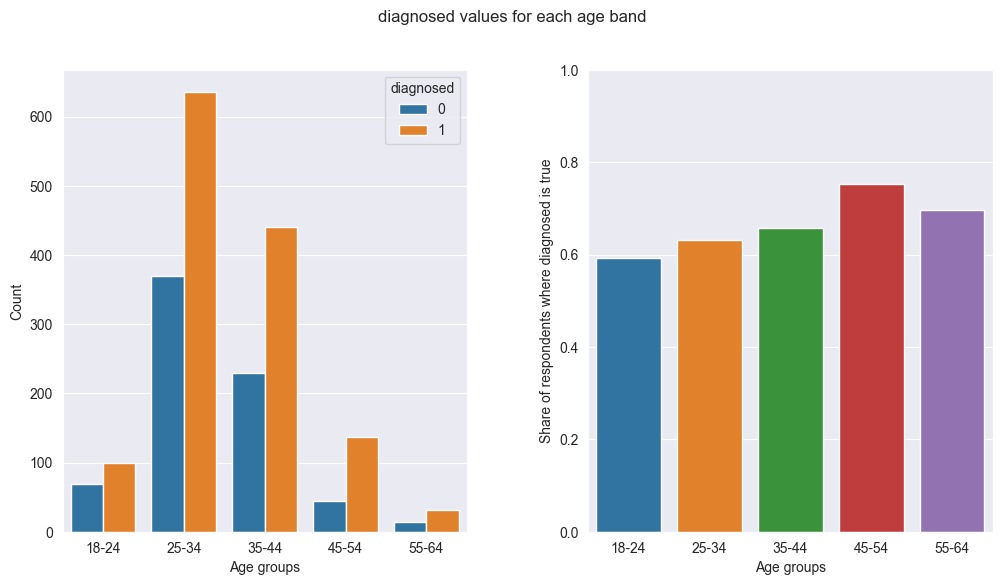

<IPython.core.display.Javascript object>

In [637]:
plot_count_percent_barplots_by_age_group(
    merged_df_diagnosed, "diagnosed", my_order=age_order
)

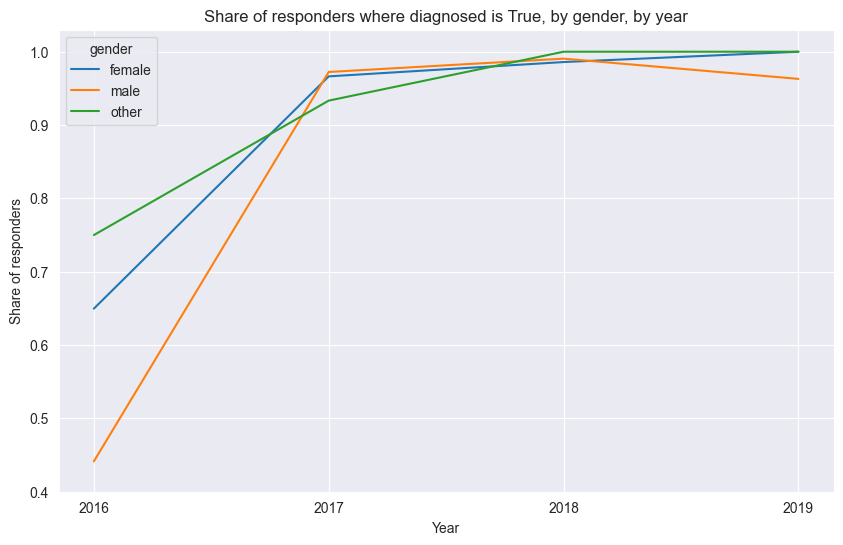

<IPython.core.display.Javascript object>

In [638]:
visualize_percentage_lineplot_by_year(merged_df_diagnosed, "diagnosed", (0.4, 1.03))

There a big share of responders who have been diagnosed with a mental health disorder at some point in their life. This share has increased throughout the years. Most people with diagnosed mental health issues are from between 25 and 45 years old.

## 2.4. What share of self-employed responders/remotely working responders have been diagnosed with a mental health disorder?

In [674]:
query_2_4 = """
            SELECT UserID AS user,
                   MAX(CASE WHEN QuestionID=118 THEN AnswerText END) AS remote,
                   MAX(CASE WHEN QuestionID=5 THEN CAST(AnswerText AS INTEGER) END) AS self_employed
            FROM Answer
            WHERE QuestionID IN (5, 118)
                  AND SurveyID != 2014
                  AND AnswerText != '-1'
            GROUP BY user
            ORDER BY user;
            """

employed_remote = pd.read_sql(query_2_4, conn)

<IPython.core.display.Javascript object>

In [675]:
# join dataframes to get all necessary data
merged_df_diagnosed_employment = employed_remote.merge(
    diagnosed, on="user", how="inner"
)

<IPython.core.display.Javascript object>

In [680]:
# check for missing values
merged_df_diagnosed_employment.isna().sum() / merged_df_diagnosed_employment.count()

user             0.000000
remote           0.461968
self_employed    0.000000
diagnosed        0.000000
dtype: float64

<IPython.core.display.Javascript object>

There are 46% of values in 'remote' column missing. We can still use the available subset for visualizations, so we won't delete rows where this column is None.

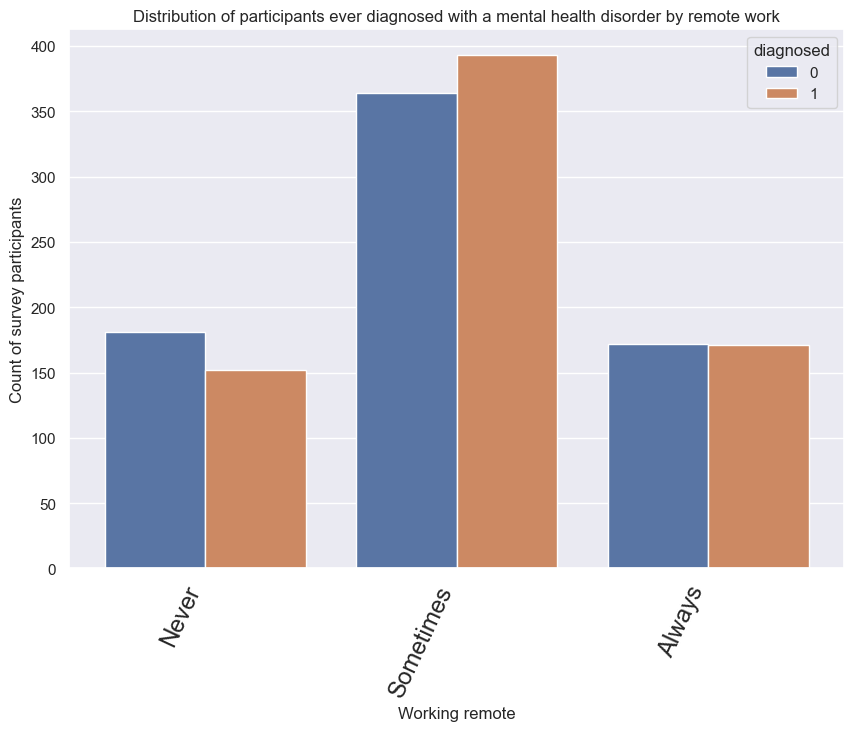

<IPython.core.display.Javascript object>

In [694]:
plot_sns_countplot(
    merged_df_diagnosed_employment,
    x="remote",
    x_label="Working remote",
    y_label="Count of survey participants",
    plot_order=["Never", "Sometimes", "Always"],
    title=f"Distribution of participants ever diagnosed with a mental health disorder by remote work",
    hue="diagnosed",
)

We can observe that the majority of participants answered that they work remotely sometimes. The lowest share of diagnosed people is among people who never work remotely. This might be due to the fact that people who have been diagnosed with a mental health disorder often choose to work remotely to avoid environmental triggers that might be present in the office.

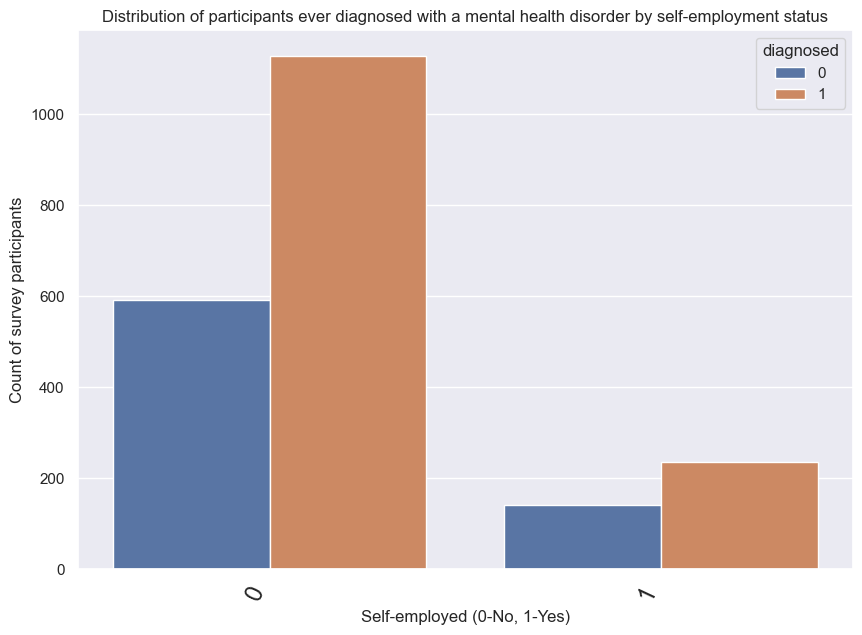

<IPython.core.display.Javascript object>

In [696]:
plot_sns_countplot(
    merged_df_diagnosed_employment,
    x="self_employed",
    x_label="Self-employed (0-No, 1-Yes)",
    y_label="Count of survey participants",
    plot_order=None,
    title=f"Distribution of participants ever diagnosed with a mental health disorder by self-employment status",
    hue="diagnosed",
)

The majority of participants in our dataset are not self-employed. The share of people who have a diagnosed mental health disorder among self-employed is a bit higher. 

# 3. Conclusion and Further Analysis

### Questions for further analysis:
- Are people whose primary role within their company is related to tech/IT more likely to be diagnosed with a mental health disorder?
- What share of the diagnosed responders have revealed their mental health issue to coworkers or employees? How does it correlate with age and gender?
- What share of the diagnosed responders are openly identified at work as a person with a mental issue? How has it affected their career?
- How many responders think that discussing a mental health issue with their employer would have negative consequences? Does it correlate with age?


### Conclusions:
- Overall, we can tell that mental health state and background is correlated with gender, age, country, and employment type.
- The median age of male responders tends to be higher than in other gender groups. And in 2016-2017 years, people who identified as of 'other' gender were mostly younger than the female group, but in 2018-2019 years older responders in 'other' gender group joined the survey. 
- The age of most responders is between 25 and 45.
- The top participant countries are: the USA, the UK, and Canada. It may be due to more attention to mental health in these countries compared to other participant counrties.
- Male participants have the lowest rate in seeking treatment from a mental health professional. 
- There is a big share of responders who have been diagnosed with a mental health disorder at some point in their life. This share has increased throughout the years. 
- Most people with a diagnosed mental health issues are between 25 and 45 years old.
- Most people with a diagnosed mental health issue are not self-employed and/or sometimes work remotely.